<div style="text-align: center;">
    <h1>  ⭐⭐⭐ User Movie Rating Prediction | Data Processing ⭐⭐⭐ </h1>
</div>

## Overview

Welcome to this notebook on constructing a movie recommendation system using user rating data. Recommender systems are a vital part of modern digital platforms, playing a crucial role in enhancing user experience by suggesting relevant content. In this project, we will build a robust movie recommendation engine for predicting user ratings.

<br></br>

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://miro.medium.com/v2/resize:fit:1358/1*wOj91RSJ3Cm4xMHwfA10Zg.png"
     alt="Movie Recommendation"
     style="float: center; padding-bottom=0.5em"
     width=600px/> 
</div>

## Technical Terms and Concepts

1. **Collaborative Filtering**: This technique involves making predictions about a user's interests by collecting preferences from many users. It operates under the assumption that if user A agrees with user B on some items, A is more likely to have B's opinion on a different item than that of a randomly chosen user.
   
2. **Content-Based Filtering**: This method recommends items based on the features of the items themselves rather than using user interactions. For example, if a user has liked movies with specific genres or actors, similar movies will be recommended.

3. **Matrix Factorization**: A technique used in collaborative filtering, where the user-item interaction matrix is decomposed into lower-dimensional matrices representing latent factors. Singular Value Decomposition (SVD) and Alternating Least Squares (ALS) are common algorithms used for this purpose.

## Business Value

The implementation of a movie recommendation system provides substantial business value, including:

1. **Increased User Satisfaction**: By offering personalised content, users are more likely to stay engaged with the platform, leading to higher user satisfaction and loyalty.

2. **Increased Sales/Conversion**: Personalised recommendations can drive higher sales and rentals of movies by suggesting items that users are more likely to purchase or rent.

3. **Improved Retention/Reduced Churn**: A well-functioning recommendation system can reduce churn rates by keeping users engaged with fresh and relevant content tailored to their tastes.

4. **Market Differentiation**: Advanced recommendation capabilities can differentiate your platform from competitors, providing a unique value proposition to users.

## Objectives

In this notebook, we will:

1. **Explore and preprocess the movie rating data**: 
   - Understand the dataset
   - Handle missing values  
   - Prepare the data for modeling
2. **Build various recommendation models**: 
   - Implement collaborative filtering 
   - Implement content-based filtering 
   - Utilise matrix factorization techniques
3. **Evaluate model performance**: 
   - Use metrics such as RMSE, precision, and recall to assess the accuracy and effectiveness of our recommendation models.
4. **Deploy the recommendation system**: 
   - Create a Streamlit app to deploy solution 
   - Use EC2 to host the App
   - Experimental tracking via CometML and versioning using Github


<h1>  DATA COLLECTION AND CURATION </h1>

Combine multiple datasets to augment the train (ratings) datasets such that we have correct formats for both collaborative and content-based filtering.

# 1. Import Libraries

In [1]:
# !pip install comet_ml surprise

In [80]:
#experimental tracking 
import comet_ml
from comet_ml import Experiment

#for data handling and arrays 
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix

#for visualisaiton
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

#for preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
import re 

#for feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

#for data partitioning 
from sklearn.model_selection import train_test_split

#for modelling   
from surprise import Reader 
from surprise import Dataset

##collaborative filtering  
from surprise import KNNWithMeans 
from surprise import KNNBasic
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

#for model optimisation and selection
from surprise.model_selection import (cross_validate, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, precision_score, recall_score)


#misc
import datetime 
from time import time 
import heapq
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

#file manangement 
import os 

#base datasets
os.environ['TRAIN_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/train.csv'
os.environ['TEST_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/test.csv'

#additional features
os.environ['TAGS_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/tags.csv'
os.environ['MOVIES_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/movies.csv'
os.environ['LINKS_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/links.csv'
os.environ['IMDB_DATA_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/imdb_data.csv'
os.environ['GENOME_TAGS_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/genome_tags.csv'
os.environ['GENOME_SCORE_PATH'] = '/kaggle/input/edsa-movie-recommendation-dataset/genome_scores.csv'

#api key 
os.environ['API_KEY'] = 'gRDjhvM5j3nQFdkpLREGdZxJ3'

#packaging models and objects 
import pickle 

#for reproducibility
SEED = 42

plt.style.use('fivethirtyeight')

In [3]:
#experimental tracking 
comet_ml.init()

experiment = Experiment(api_key = os.environ.get('API_KEY'),
                        project_name = 'movie-recommender-system',
                        workspace = 'nomaguguk')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nomaguguk/movie-recommender-system/3c449bca70794f7dbeca866712c27943



# 2. Import Datasets

In [4]:
def dataframe_info(df):
    '''
    This function prints out information about the dataframe
    
    Args:
        df (pd.DataFrame): dataframe to be summarised 
    '''
    print(f"The dataset contains {df.shape[0]} samples and {df.shape[1]} features")

In [5]:
#load train dataset (with user and item interactions | ratings) | sample due to memory limitationas
df_ratings = pd.read_csv(os.environ.get('TRAIN_PATH'))
df_ratings = df_ratings.sample(n = 50000, replace = False, random_state=SEED).reset_index(drop = True)

In [6]:
#view 
df_ratings.head()

,userId,movieId,rating,timestamp
0,122380,31445,2.5,1159967140
1,22380,56775,4.0,1343936580
2,104339,356,2.5,1111529397
3,64877,6874,4.0,1513800297
4,63164,2762,5.0,1005315064


In [7]:
#view ratings dataset
dataframe_info(df_ratings)

The dataset contains 50000 samples and 4 features


In [8]:
#load movies dataset
df_movies = pd.read_csv(os.environ.get('MOVIES_PATH'))
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
#view movies dataset
dataframe_info(df_movies)

The dataset contains 62423 samples and 3 features


In [10]:
#load tags dataset
df_tags = pd.read_csv(os.environ.get('TAGS_PATH'))
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
#view tags dataset
dataframe_info(df_tags)

The dataset contains 1093360 samples and 4 features


In [12]:
#load tags dataset
df_links = pd.read_csv(os.environ.get('LINKS_PATH'))
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
#view links dataset
dataframe_info(df_links)

The dataset contains 62423 samples and 3 features


In [14]:
#load imdb dataset
df_imdb = pd.read_csv(os.environ.get('IMDB_DATA_PATH'))
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [15]:
#view imdb dataset
dataframe_info(df_imdb)

The dataset contains 27278 samples and 6 features


In [16]:
#load genome scores dataset
df_genome_scores = pd.read_csv(os.environ.get('GENOME_SCORE_PATH'))
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [17]:
#view imdb dataset
dataframe_info(df_genome_scores)

The dataset contains 15584448 samples and 3 features


In [18]:
#load genome tags dataset
df_genome_tags = pd.read_csv(os.environ.get('GENOME_TAGS_PATH'))
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [19]:
#view genome tags dataset
dataframe_info(df_genome_tags)

The dataset contains 1128 samples and 2 features


# 3.  Data Curation

## 3.1. Collaborative Filtering Dataset

For collaborative filtering dataset, we must create a utility matrix (matrix made up users and movies (items) with their interactions (rating). In collaborarive filtering, as mentioned earlier, we aim to recommend the best movies and predict ratings based on similarity between user preferences. 

To this end, we will combine the base training dataset and movies dataset

In [20]:
df_ratings.head(2)

,userId,movieId,rating,timestamp
0,122380,31445,2.5,1159967140
1,22380,56775,4.0,1343936580


In [21]:
df_movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [22]:
#merge users, ratings and movie titles
df_collab = pd.merge(left = df_ratings,
                     right = df_movies,
                     how = 'left',
                     on = 'movieId')

In [23]:
#view
df_collab.head()

,userId,movieId,rating,timestamp,title,genres
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery


In [24]:
#drop movies id
df_collab_usr = df_collab[['userId', 'movieId', 'rating', 'title']]

In [25]:
#view (DATASET 1)
df_collab_usr.head()

,userId,movieId,rating,title
0,122380,31445,2.5,Employee of the Month (2004)
1,22380,56775,4.0,National Treasure: Book of Secrets (2007)
2,104339,356,2.5,Forrest Gump (1994)
3,64877,6874,4.0,Kill Bill: Vol. 1 (2003)
4,63164,2762,5.0,"Sixth Sense, The (1999)"


In [26]:
#create utility matrix
utility_matrix = df_collab.pivot_table(values = ['rating'],
                                       index = ['userId'],
                                       columns = ['title'])

In [27]:
#view
utility_matrix.head()

rating                                                         \
title  $9.99 (2008) 'Neath the Arizona Skies (1934) 'Round Midnight (1986)   
userId                                                                       
2               NaN                             NaN                    NaN   
12              NaN                             NaN                    NaN   
18              NaN                             NaN                    NaN   
21              NaN                             NaN                    NaN   
31              NaN                             NaN                    NaN   

                                                                          \
title  'Til There Was You (1997) 'burbs, The (1989) 'night Mother (1986)   
userId                                                                     
2                            NaN                NaN                  NaN   
12                           NaN                NaN                  NaN   
18                           NaN                NaN                  NaN   
21                           NaN                NaN                  NaN   
31                           NaN                NaN                  NaN   

                                                                   \
title  (500) Days of Summer (2009) *batteries not included (1987)   
userId                                                              
2                              NaN                            NaN   
12                             NaN                            NaN   
18                             NaN                            NaN   
21                             NaN                            NaN   
31                             NaN                            NaN   

                                                ...               \
title  ...And Justice for All (1979) 10 (1979)  ... [REC] (2007)   
userId                                          ...                
2                                NaN       NaN  ...          NaN   
12                               NaN       NaN  ...          NaN   
18                               NaN       NaN  ...          NaN   
21                               NaN       NaN  ...          NaN   
31                               NaN       NaN  ...          NaN   

                                                               \
title  [REC]² (2009) eCupid (2011) eXistenZ (1999) xXx (2002)   
userId                                                          
2                NaN           NaN             NaN        NaN   
12               NaN           NaN             NaN        NaN   
18               NaN           NaN             NaN        NaN   
21               NaN           NaN             NaN        NaN   
31               NaN           NaN             NaN        NaN   

                                                                         \
title  xXx: Return of Xander Cage (2017) xXx: State of the Union (2005)   
userId                                                                    
2                                    NaN                            NaN   
12                                   NaN                            NaN   
18                                   NaN                            NaN   
21                                   NaN                            NaN   
31                                   NaN                            NaN   

                                                        
title  ¡Three Amigos! (1986) Я худею (2018) به نام پدر  
userId                                                  
2                        NaN            NaN        NaN  
12                       NaN            NaN        NaN  
18                       NaN            NaN        NaN  
21                       NaN            NaN        NaN  
31                       NaN            NaN        NaN  

[5 rows x 7804 columns]

In [28]:
#view information tags dataset
dataframe_info(utility_matrix)

The dataset contains 34365 samples and 7804 features


## 3.2. Content-based Filtering Dataset

For content-based filtering dataset, we must heavy use of features which describe the movies. This is because recommendations from content-based recommenders rely on similarity betwen items, thus the more detailed the descriptions, the better. To this end, we will combine the following datasets:

- Training (rating dataset)
- Tags 
- IMDB (which will be linked to Movies dataset via Links)
- Genome tags (in which we will consider the highest score and link to Movies)

We will also add running time for analytics purposes

In [29]:
#review base collaborative filtering dataset
df_collab.head()

,userId,movieId,rating,timestamp,title,genres
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery


In [30]:
#remove missing tags 
df_tags.dropna(subset = ['tag'], inplace = True)

In [31]:
#aggregate tags by user and movie
df_tags_agg = df_tags.groupby(['userId', 'movieId'])['tag'].agg('|'.join).reset_index()

In [32]:
df_tags_agg.head()

,userId,movieId,tag
0,3,260,classic|sci-fi
1,4,1732,dark comedy|great dialogue
2,4,7569,so bad it's good
3,4,44665,unreliable narrators
4,4,115569,tense


In [33]:
#combine with train + movies datasets
df_collab_w_tags = pd.merge(left = df_collab,
                             right = df_tags_agg,
                             how = 'left',
                             on = ['userId','movieId'])

In [34]:
#view
df_collab_w_tags.head()

,userId,movieId,rating,timestamp,title,genres,tag
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN


In [35]:
df_collab_w_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  int64  
 1   movieId    50000 non-null  int64  
 2   rating     50000 non-null  float64
 3   timestamp  50000 non-null  int64  
 4   title      50000 non-null  object 
 5   genres     50000 non-null  object 
 6   tag        432 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [36]:
#combine with imdb dataset
df_content_filt_inter = pd.merge(left = df_collab_w_tags,
                                 right = df_imdb,
                                 how = 'left',
                                 on = 'movieId')

df_content_filt_inter.head()

,userId,movieId,rating,timestamp,title,genres,tag,title_cast,director,runtime,budget,plot_keywords
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...


In [37]:
df_genome_scores.head(3)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


In [38]:
#finally add genome tags 
#bring the tagid with the highest relevance
df_genome_scores_filtered = df_genome_scores.sort_values(by = ['movieId', 'relevance'], ascending = [True, False]).drop_duplicates(subset = ['movieId'], keep = 'first')[['movieId', 'tagId']]

In [39]:
#view 
df_genome_scores_filtered.head()

,movieId,tagId
1035,1,1036
1156,2,29
3156,3,901
4499,4,1116
5412,5,901


In [40]:
#check info 
dataframe_info(df_genome_tags)

The dataset contains 1128 samples and 2 features


In [41]:
#view
df_genome_tags.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [42]:
#map movies to genome
df_genome_combined = pd.merge(left = df_genome_scores_filtered,
                             right = df_genome_tags,
                             how = 'left',
                             on = 'tagId')

In [43]:
df_genome_combined.head()

,movieId,tagId,tag
0,1,1036,toys
1,2,29,adventure
2,3,901,sequel
3,4,1116,women
4,5,901,sequel


In [44]:
#combine the base content data with genome scoring 
df_content_filt_inter.head()

,userId,movieId,rating,timestamp,title,genres,tag,title_cast,director,runtime,budget,plot_keywords
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...


In [45]:
#map movies to genome
df_content_filt = pd.merge(left = df_content_filt_inter,
                             right = df_genome_combined,
                             how = 'left',
                             on = 'movieId')

In [46]:
#view
df_content_filt.head()

,userId,movieId,rating,timestamp,title,genres,tag_x,title_cast,director,runtime,budget,plot_keywords,tagId,tag_y
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker,994.0,surprise ending
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...,1044.0,treasure hunt
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book,754.0,oscar (best music - original score)
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist,146.0,bloody
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...,436.0,ghosts/afterlife


In [47]:
#check info
dataframe_info(df_content_filt)

The dataset contains 50000 samples and 14 features


<h1>  DATA CLEANING AND EXPLORATION </h1>

Handling Missing Data: Remove or impute missing values.
Duplicate Removal: Ensure no duplicate entries in user profiles or movie details.
Data Consistency: Normalize data formats, such as dates and genres.

# 4. Data Exploration

### 4.1. Ratings Sparsity

In [48]:
#view utility matrix
utility_matrix.head()

rating                                                         \
title  $9.99 (2008) 'Neath the Arizona Skies (1934) 'Round Midnight (1986)   
userId                                                                       
2               NaN                             NaN                    NaN   
12              NaN                             NaN                    NaN   
18              NaN                             NaN                    NaN   
21              NaN                             NaN                    NaN   
31              NaN                             NaN                    NaN   

                                                                          \
title  'Til There Was You (1997) 'burbs, The (1989) 'night Mother (1986)   
userId                                                                     
2                            NaN                NaN                  NaN   
12                           NaN                NaN                  NaN   
18                           NaN                NaN                  NaN   
21                           NaN                NaN                  NaN   
31                           NaN                NaN                  NaN   

                                                                   \
title  (500) Days of Summer (2009) *batteries not included (1987)   
userId                                                              
2                              NaN                            NaN   
12                             NaN                            NaN   
18                             NaN                            NaN   
21                             NaN                            NaN   
31                             NaN                            NaN   

                                                ...               \
title  ...And Justice for All (1979) 10 (1979)  ... [REC] (2007)   
userId                                          ...                
2                                NaN       NaN  ...          NaN   
12                               NaN       NaN  ...          NaN   
18                               NaN       NaN  ...          NaN   
21                               NaN       NaN  ...          NaN   
31                               NaN       NaN  ...          NaN   

                                                               \
title  [REC]² (2009) eCupid (2011) eXistenZ (1999) xXx (2002)   
userId                                                          
2                NaN           NaN             NaN        NaN   
12               NaN           NaN             NaN        NaN   
18               NaN           NaN             NaN        NaN   
21               NaN           NaN             NaN        NaN   
31               NaN           NaN             NaN        NaN   

                                                                         \
title  xXx: Return of Xander Cage (2017) xXx: State of the Union (2005)   
userId                                                                    
2                                    NaN                            NaN   
12                                   NaN                            NaN   
18                                   NaN                            NaN   
21                                   NaN                            NaN   
31                                   NaN                            NaN   

                                                        
title  ¡Three Amigos! (1986) Я худею (2018) به نام پدر  
userId                                                  
2                        NaN            NaN        NaN  
12                       NaN            NaN        NaN  
18                       NaN            NaN        NaN  
21                       NaN            NaN        NaN  
31                       NaN            NaN        NaN  

[5 rows x 7804 columns]

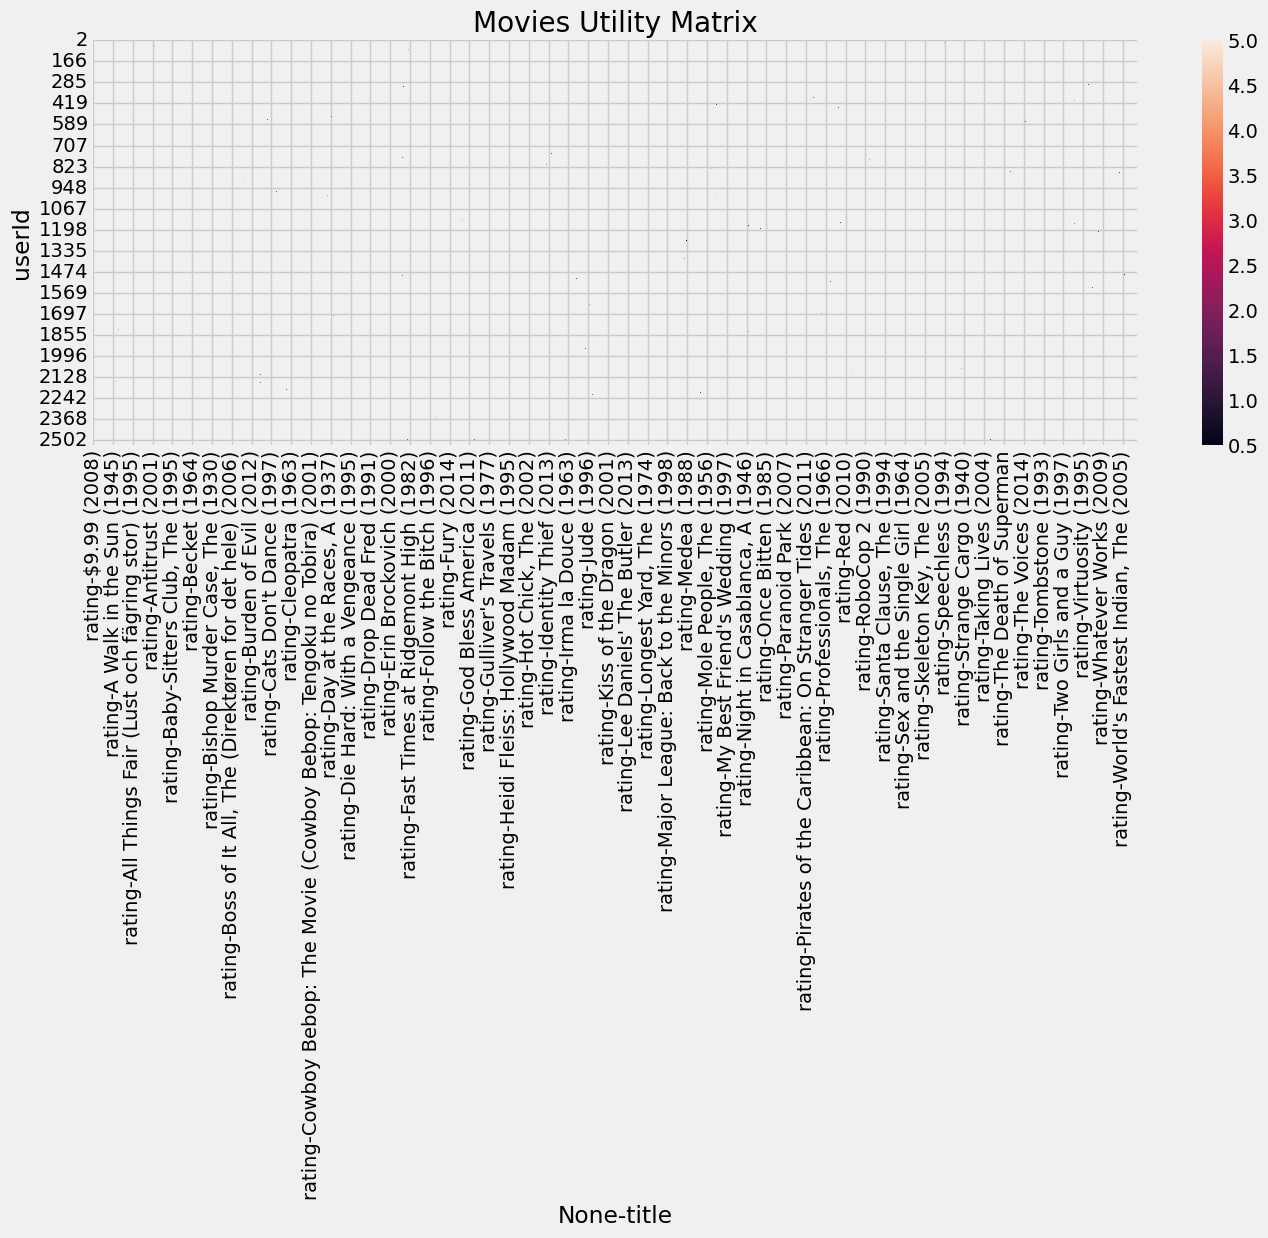

In [49]:
# We select only the first 100 users for ease of computation and visualisation. 
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.heatmap(utility_matrix[0:500], annot=False, ax=ax).set_title('Movies Utility Matrix')

In [50]:
#check sparsity 
print(f"The utility dataset has {100*(utility_matrix.isna().sum().sum())/(utility_matrix.size):.2f}% missing values")

The utility dataset has 99.98% missing values


### 4.1.2. Ratings Distrbution

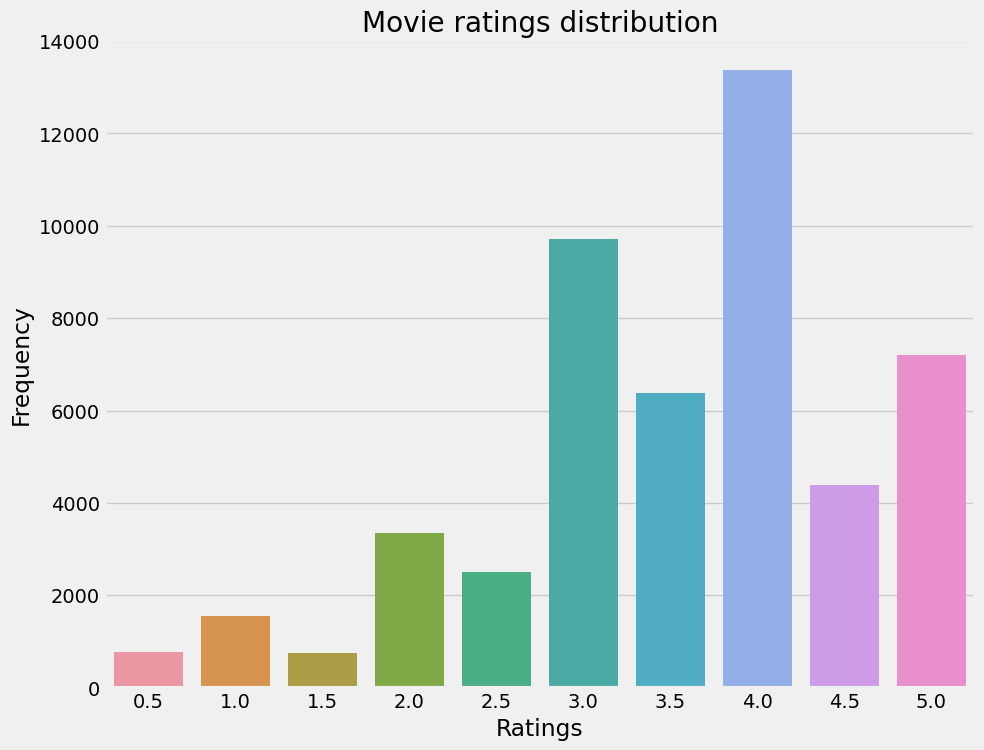

In [51]:
plt.figure(figsize=(10,8))
sns.countplot(x = 'rating', data = df_ratings)
plt.title('Movie ratings distribution')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

In [52]:
#stastical summmary 
df_ratings['rating'].describe()

count    50000.000000
mean         3.535880
std          1.058686
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

### 4.1.3. Movies and Novelty

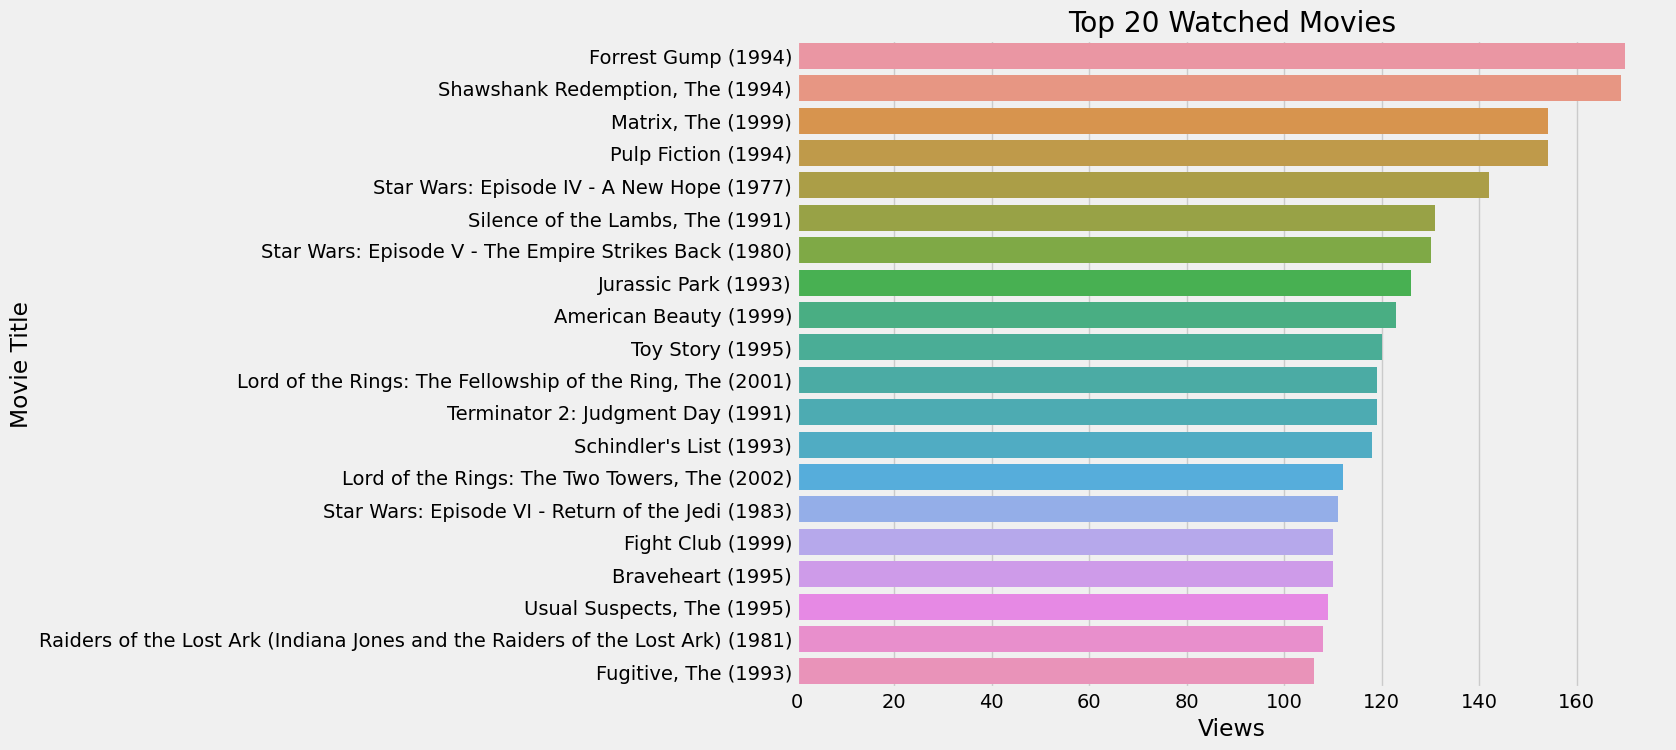

In [53]:
#movie distribution
plt.figure(figsize=(10,8))
sns.countplot(y = 'title', data = df_collab, order = df_collab['title'].value_counts()[:20].index)
plt.title('Top 20 Watched Movies')
plt.xlabel('Views')
plt.ylabel('Movie Title')
plt.show()

In [54]:
#get average ratings
df_top = df_collab.groupby('title')['rating'].agg(['mean', 'count']).reset_index()

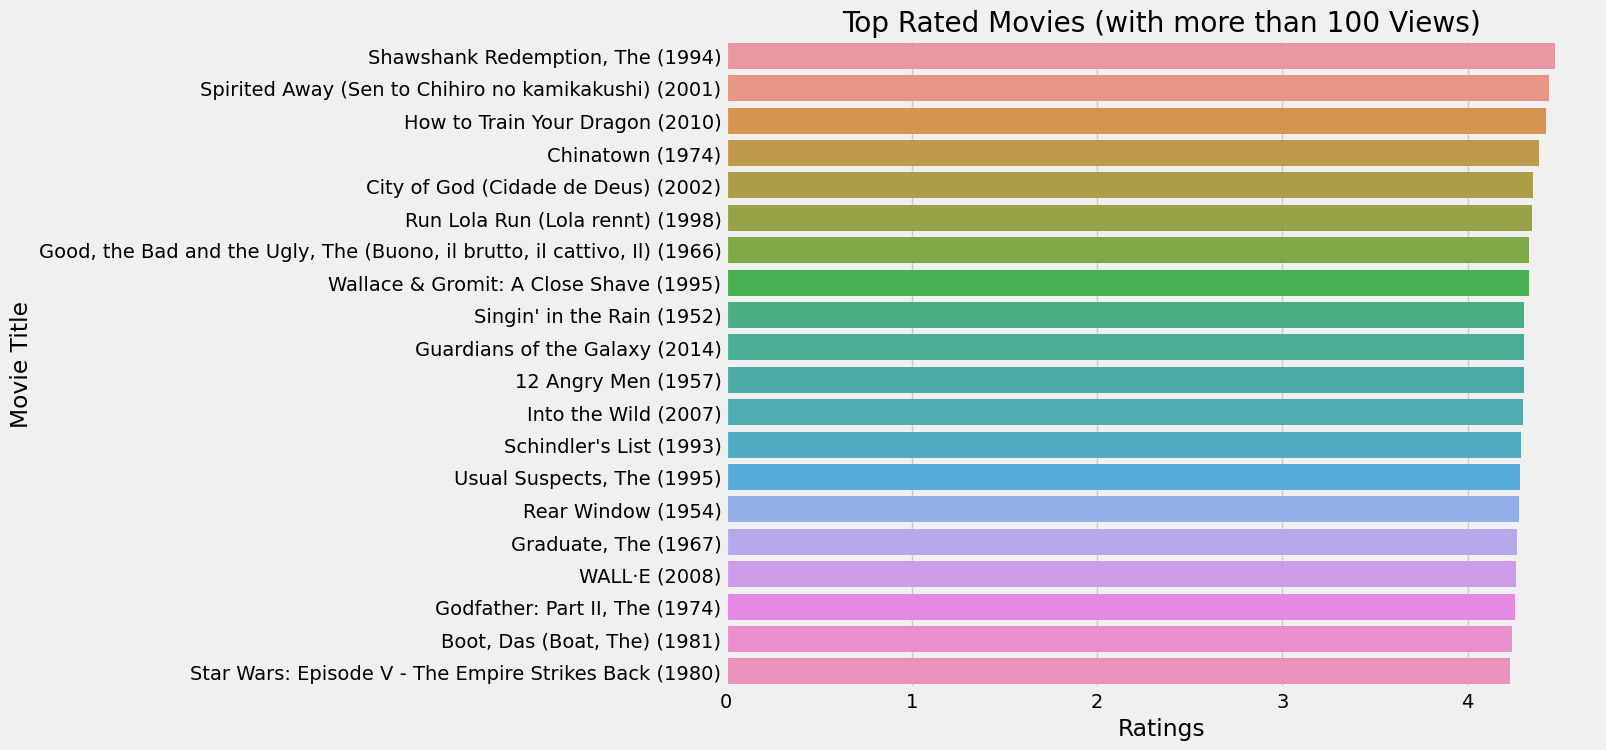

In [55]:
df_more_100_top = df_top[df_top['count']>=20].sort_values(by = 'mean', ascending = False)[:20]

#movie distribution
plt.figure(figsize=(10,8))
sns.barplot(y = 'title', x = 'mean',  data =df_more_100_top)
plt.title('Top Rated Movies (with more than 100 Views)')
plt.xlabel('Ratings')
plt.ylabel('Movie Title')
plt.show()

### 4.1.4. Ratings by Running Time

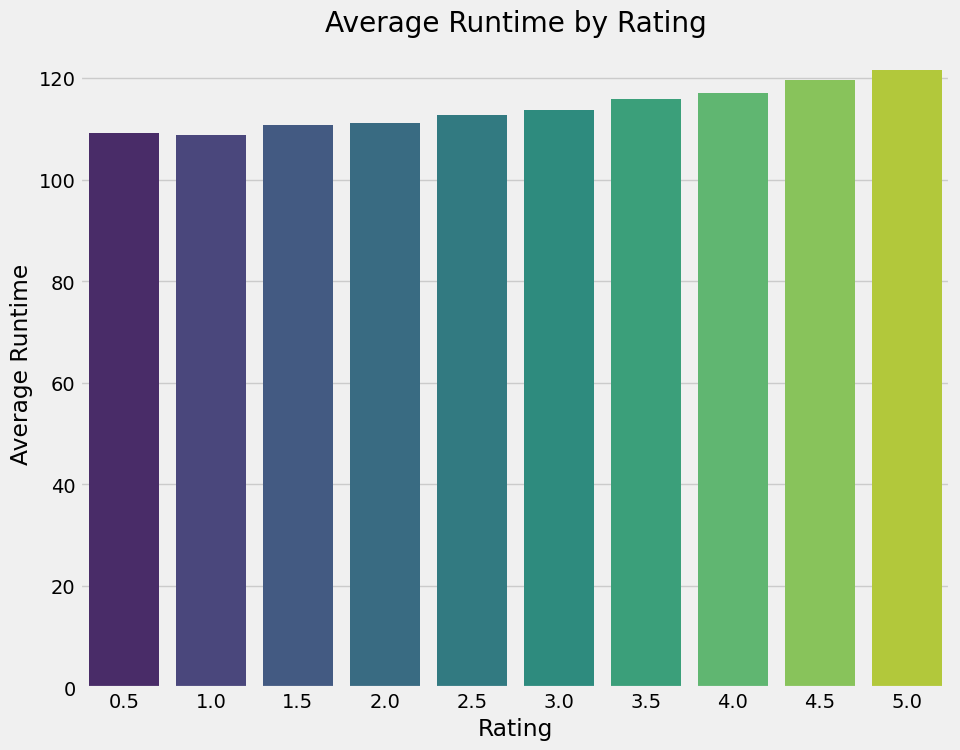

In [56]:
# Calculate the average runtime for each rating
average_runtime = df_content_filt.groupby('rating')['runtime'].mean().reset_index()

# Set the figure size
plt.figure(figsize=(10, 8))
sns.barplot(x='rating', y='runtime', data=average_runtime, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Average Runtime')
plt.title('Average Runtime by Rating')
plt.show()

## 4.2. Data Cleaning

### Collaborative Filtering

In [57]:
#view
utility_matrix.head(3)

rating                                                         \
title  $9.99 (2008) 'Neath the Arizona Skies (1934) 'Round Midnight (1986)   
userId                                                                       
2               NaN                             NaN                    NaN   
12              NaN                             NaN                    NaN   
18              NaN                             NaN                    NaN   

                                                                          \
title  'Til There Was You (1997) 'burbs, The (1989) 'night Mother (1986)   
userId                                                                     
2                            NaN                NaN                  NaN   
12                           NaN                NaN                  NaN   
18                           NaN                NaN                  NaN   

                                                                   \
title  (500) Days of Summer (2009) *batteries not included (1987)   
userId                                                              
2                              NaN                            NaN   
12                             NaN                            NaN   
18                             NaN                            NaN   

                                                ...               \
title  ...And Justice for All (1979) 10 (1979)  ... [REC] (2007)   
userId                                          ...                
2                                NaN       NaN  ...          NaN   
12                               NaN       NaN  ...          NaN   
18                               NaN       NaN  ...          NaN   

                                                               \
title  [REC]² (2009) eCupid (2011) eXistenZ (1999) xXx (2002)   
userId                                                          
2                NaN           NaN             NaN        NaN   
12               NaN           NaN             NaN        NaN   
18               NaN           NaN             NaN        NaN   

                                                                         \
title  xXx: Return of Xander Cage (2017) xXx: State of the Union (2005)   
userId                                                                    
2                                    NaN                            NaN   
12                                   NaN                            NaN   
18                                   NaN                            NaN   

                                                        
title  ¡Three Amigos! (1986) Я худею (2018) به نام پدر  
userId                                                  
2                        NaN            NaN        NaN  
12                       NaN            NaN        NaN  
18                       NaN            NaN        NaN  

[3 rows x 7804 columns]

In [58]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = utility_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's and 
util_matrix_norm.fillna(0, inplace=True)
#transpose matrix
util_matrix_norm = util_matrix_norm.T
# drop users with no ratings
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = csr_matrix(util_matrix_norm.values)

In [59]:
#view
util_matrix_norm.head()

userId                                  12      59      80      120     \
       title                                                             
rating $9.99 (2008)                        0.0     0.0     0.0     0.0   
       'Neath the Arizona Skies (1934)     0.0     0.0     0.0     0.0   
       'Round Midnight (1986)              0.0     0.0     0.0     0.0   
       'Til There Was You (1997)           0.0     0.0     0.0     0.0   
       'burbs, The (1989)                  0.0     0.0     0.0     0.0   

userId                                  166     175     181     187     \
       title                                                             
rating $9.99 (2008)                        0.0     0.0     0.0     0.0   
       'Neath the Arizona Skies (1934)     0.0     0.0     0.0     0.0   
       'Round Midnight (1986)              0.0     0.0     0.0     0.0   
       'Til There Was You (1997)           0.0     0.0     0.0     0.0   
       'burbs, The (1989)                  0.0     0.0     0.0     0.0   

userId                                  243     256     ...  162331  162355  \
       title                                            ...                   
rating $9.99 (2008)                        0.0     0.0  ...     0.0     0.0   
       'Neath the Arizona Skies (1934)     0.0     0.0  ...     0.0     0.0   
       'Round Midnight (1986)              0.0     0.0  ...     0.0     0.0   
       'Til There Was You (1997)           0.0     0.0  ...     0.0     0.0   
       'burbs, The (1989)                  0.0     0.0  ...     0.0     0.0   

userId                                  162386  162447  162472  162480  \
       title                                                             
rating $9.99 (2008)                        0.0     0.0     0.0     0.0   
       'Neath the Arizona Skies (1934)     0.0     0.0     0.0     0.0   
       'Round Midnight (1986)              0.0     0.0     0.0     0.0   
       'Til There Was You (1997)           0.0     0.0     0.0     0.0   
       'burbs, The (1989)                  0.0     0.0     0.0     0.0   

userId                                  162508  162516  162521  162529  
       title                                                            
rating $9.99 (2008)                        0.0     0.0     0.0     0.0  
       'Neath the Arizona Skies (1934)     0.0     0.0     0.0     0.0  
       'Round Midnight (1986)              0.0     0.0     0.0     0.0  
       'Til There Was You (1997)           0.0     0.0     0.0     0.0  
       'burbs, The (1989)                  0.0     0.0     0.0     0.0  

[5 rows x 7777 columns]

# 5. Feature Extraction

In [60]:
#base ratings table (DATASET 1)
df_collab_usr.head()

,userId,movieId,rating,title
0,122380,31445,2.5,Employee of the Month (2004)
1,22380,56775,4.0,National Treasure: Book of Secrets (2007)
2,104339,356,2.5,Forrest Gump (1994)
3,64877,6874,4.0,Kill Bill: Vol. 1 (2003)
4,63164,2762,5.0,"Sixth Sense, The (1999)"


### Content-based Filtering

We will combine all the features which are relevant in describing the movie, as such the following features will be concatenated to create a title tag

- genres
- tag_x (combination of actors and genres)
- title cast 
- director
- plot keywords
- tag_y (subjective reviews)

In [63]:
#view
df_content_filt.head()

,userId,movieId,rating,timestamp,title,genres,tag_x,title_cast,director,runtime,budget,plot_keywords,tagId,tag_y
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker,994.0,surprise ending
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...,1044.0,treasure hunt
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book,754.0,oscar (best music - original score)
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist,146.0,bloody
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...,436.0,ghosts/afterlife


In [64]:
# Concatenate genres, title cast, director, plot keywords, and tag_y into a single column
df_content_filt['stage_genres'] = df_content_filt['genres'] + '|' + df_content_filt['title_cast'] + '|' + df_content_filt['director'] + '|' + df_content_filt['plot_keywords'] + '|' + df_content_filt['tag_y']
df_content_filt.head()

,userId,movieId,rating,timestamp,title,genres,tag_x,title_cast,director,runtime,budget,plot_keywords,tagId,tag_y,stage_genres
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker,994.0,surprise ending,Comedy|Drama|Matt Dillon|Steve Zahn|Christina ...
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...,1044.0,treasure hunt,Action|Adventure|Nicolas Cage|Justin Bartha|Di...
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book,754.0,oscar (best music - original score),Comedy|Drama|Romance|War|Tom Hanks|Rebecca Wil...
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist,146.0,bloody,Action|Crime|Thriller|Uma Thurman|Lucy Liu|Viv...
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...,436.0,ghosts/afterlife,Drama|Horror|Mystery|Bruce Willis|Haley Joel O...


In [65]:
# Remove any NaN values and duplicates from the stage genres column
df_content_filt['movie_tag'] = df_content_filt['stage_genres'].str.lower().fillna('').apply(lambda x: '|'.join(set(x.split('|'))))
df_content_filt['movie_tag'] = df_content_filt['movie_tag'].str.replace('|', ' ')

In [66]:
#view
df_content_filt.head()

,userId,movieId,rating,timestamp,title,genres,tag_x,title_cast,director,runtime,budget,plot_keywords,tagId,tag_y,stage_genres,movie_tag
0,122380,31445,2.5,1159967140,Employee of the Month (2004),Comedy|Drama,NaN,Matt Dillon|Steve Zahn|Christina Applegate|And...,Mitch Rouse,97.0,NaN,hare krishna|bank|engagement|hooker,994.0,surprise ending,Comedy|Drama|Matt Dillon|Steve Zahn|Christina ...,dave foley brian blondell surprise ending dram...
1,22380,56775,4.0,1343936580,National Treasure: Book of Secrets (2007),Action|Adventure,NaN,Nicolas Cage|Justin Bartha|Diane Kruger|Jon Vo...,Abraham Lincoln,124.0,"$130,000,000",cleavage|divorce|abraham lincoln character|joh...,1044.0,treasure hunt,Action|Adventure|Nicolas Cage|Justin Bartha|Di...,cleavage john wilkes booth character albert ha...
2,104339,356,2.5,1111529397,Forrest Gump (1994),Comedy|Drama|Romance|War,NaN,Tom Hanks|Rebecca Williams|Sally Field|Michael...,Winston Groom,142.0,"$55,000,000",vietnam war|amputee|war hero|based on book,754.0,oscar (best music - original score),Comedy|Drama|Romance|War|Tom Hanks|Rebecca Wil...,based on book harold g. herthum rebecca willia...
3,64877,6874,4.0,1513800297,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller,NaN,Uma Thurman|Lucy Liu|Vivica A. Fox|Daryl Hanna...,Quentin Tarantino,111.0,"$30,000,000",revenge|bride|sword|female protagonist,146.0,bloody,Action|Crime|Thriller|Uma Thurman|Lucy Liu|Viv...,yuki kazamatsuri sword david carradine shin'ic...
4,63164,2762,5.0,1005315064,"Sixth Sense, The (1999)",Drama|Horror|Mystery,NaN,Bruce Willis|Haley Joel Osment|Toni Collette|O...,M. Night Shyamalan,107.0,"$40,000,000",surprise ending|single mother|able to see the ...,436.0,ghosts/afterlife,Drama|Horror|Mystery|Bruce Willis|Haley Joel O...,horror mystery greg wood olivia williams surpr...


In [86]:
#create final datasets for content-based 
titles = df_content_filt['title'].unique()
indices = pd.Series(index=titles, data=range(len(titles)))

In [70]:
## Split the dataset
train_data_collab, validation_data_collab = train_test_split(df_content_filt, test_size=0.05, random_state=42)

In [73]:
train_data_collab.head(5)

,userId,movieId,rating,timestamp,title,genres,tag_x,title_cast,director,runtime,budget,plot_keywords,tagId,tag_y,stage_genres,movie_tag
10453,146506,8207,4.0,1429832828,"Day of the Jackal, The (1973)",Crime|Thriller,NaN,NaN,NaN,NaN,NaN,NaN,81.0,assassin,NaN,
18377,101729,104841,5.0,1564783306,Gravity (2013),Action|Sci-Fi|IMAX,cinematography|sci-fi|science|space,Sandra Bullock|George Clooney|Ed Harris|Orto I...,Alfonso Cuarón,91.0,"$100,000,000",female protagonist|space station|sole survivor...,84.0,astronauts,Action|Sci-Fi|IMAX|Sandra Bullock|George Cloon...,female protagonist sole survivor ed harris pha...
20737,7681,6808,4.5,1111472337,Where Eagles Dare (1968),Action|Adventure|War,NaN,NaN,NaN,NaN,NaN,NaN,1121.0,world war ii,NaN,
43335,143578,4042,4.0,978883151,"Alamo, The (1960)",Action|Drama|War|Western,NaN,NaN,NaN,NaN,NaN,NaN,509.0,history,NaN,
8393,37452,5568,3.0,1041614055,Johnny Dangerously (1984),Comedy,NaN,NaN,NaN,NaN,NaN,NaN,958.0,spoof,NaN,


In [75]:
#use tf-idf to vectorise movie tags
tf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                               min_df = 0, stop_words='english')

#create a vectorization representation
tfidf_matrix_train_collab = tf_vectorizer.fit_transform(train_data_collab['movie_tag'])
tfidf_matrix_validation_collab = tf_vectorizer.fit_transform(validation_data_collab['movie_tag'])

In [76]:
#create a similary matrix between movies based on tag description
cosine_sim_train_collab = cosine_similarity(tfidf_matrix_train_collab, tfidf_matrix_train_collab)
cosine_sim_validation_collab = cosine_similarity(tfidf_matrix_validation_collab, tfidf_matrix_validation_collab)

In [79]:
#info
print(f"The training cosine similarity matrix for movie tags has {cosine_sim_train_collab.shape[0]} rows and {cosine_sim_train_collab.shape[1]} columns")

The training cosine similarity matrix for movie tags has 47500 rows and 47500 columns


# 6. Modelling | Rating Prediction

### Content-Based Filtering Models

Use user-defined functions and cosine similairy score to predict ratings based on item similarity (defined by features)

In [87]:
# Define the rating prediction function
def content_generate_rating_estimate(movie_title, userId, rating_data, cosine_sim_matrix, k=20, threshold=0.0):
    m_idx = indices[movie_title]
    neighbors = []

    for index, row in rating_data[rating_data['userId'] == userId].iterrows():
        sim = cosine_sim_matrix[m_idx-1, indices[row['title']]-1]
        if isinstance(sim, np.ndarray):
            sim = sim.flatten()[0]
        neighbors.append((sim, row['rating']))

    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])
    simTotal, weightedSum = 0, 0

    for (simScore, rating) in k_neighbors:
        if simScore > threshold:
            simTotal += simScore
            weightedSum += simScore * rating

    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        predictedRating = np.mean(rating_data[rating_data['title'] == movie_title]['rating'])
    
    return predictedRating

In [89]:
# Predict ratings
predicted_ratings = []
actual_ratings = []

for index, row in validation_data_collab.head(5).iterrows():
    predicted_rating = content_generate_rating_estimate(movie_title=row['title'], userId=row['userId'], rating_data=df_collab_usr, cosine_sim_matrix=cosine_sim_train_collab)
    predicted_ratings.append(predicted_rating)
    actual_ratings.append(row['rating'])

In [94]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
mae = mean_absolute_error(actual_ratings, predicted_ratings)

# Calculate Hit Rate and Coverage
hit_count = 0
total_count = len(validation_data_collab)
threshold = 0.5

for actual, predicted in zip(actual_ratings, predicted_ratings):
    if abs(actual - predicted) <= threshold:
        hit_count += 1

hit_rate = hit_count / total_count
coverage = len(predicted_ratings) / len(train_data_collab['movieId'].unique())

# Calculate Precision and Recall
binary_actual = [1 if rating >= 3 else 0 for rating in actual_ratings]
binary_predicted = [1 if rating >= 3 else 0 for rating in predicted_ratings]

precision = precision_score(binary_actual, binary_predicted)
recall = recall_score(binary_actual, binary_predicted)

# Print metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Hit Rate: {100*hit_rate:.2f}%")
print(f"Coverage: {100*coverage:.2f}%")
print(f"Precision: {100*precision:.2f}%")
print(f"Recall: {100*recall:.2f}%")

RMSE: 0.95
MAE: 0.43
Hit Rate: 0.16%
Coverage: 0.07%
Precision: 100.00%
Recall: 75.00%


In [ ]:
# Test the function
title = "Forrest Gump (1994)"
actual_rating = df_collab_usr[(df_collab_usr['userId'] == 104339) & (df_collab_usr['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, userId=104339, rating_data=df_collab_usr)
print(f"Title - {title}")
print("---")
print(f"Actual rating: \t\t {actual_rating}")
print(f"Predicted rating: \t {pred_rating}")

In [ ]:
#test 
title = "Kill Bill: Vol. 1 (2003)"
actual_rating = df_collab_usr[(df_collab_usr['userId'] == 64877) & (df_collab_usr['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, userId=64877, rating_data=df_collab_usr)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

### Collaborative Filtering Models

We will make use of matrix factorization and neighhbour-based methods which have been astracted in the `surprise` library

In [ ]:
df_collab_usr.head()

# 7 . Model Selection
Compare Models: Use evaluation metrics to compare different models.
Select Best Model: Choose the model with the best performance for deployment.


Split Data: Split data into training and test sets.
Cross-Validation: Use k-fold cross-validation to tune hyperparameters and avoid overfitting.
Evaluation Metrics:

RMSE and MAE: Evaluate prediction accuracy using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).
Hit Rate and Coverage: Assess recommendation relevance and diversity.
Precision and Recall: Measure the proportion of relevant recommended items and the proportion of relevant items recommended.

# 8. Test Dataset Evaluation | Inference

In [ ]:
#load and view test dataset
df_test = pd.read_csv(os.environ.get('TEST_PATH'))
df_test.head()

In [ ]:
#info
dataframe_info(df_test)

In [ ]:
#evaluation


In [ ]:
#save results

# 9. Notes

## Deployment
Streamlit for Deployment:

- Create Interface: Develop a user-friendly interface using Streamlit to display recommendations.
- Integrate Models: Load trained models and use them to generate recommendations based on user input.
- Feedback Loop: Allow users to provide feedback to continually improve the recommendation system.

**to be done**

## Versioning and Communication

**Version control:** 

We used git to version our code. The current notebook and artifacts can be found in `https://github.com/nomaguguk/edsa-movie-recommender-system`

**Experiment Tracking:** 

We also made use of `Comet ML` to keep track of outputs and experimental outcomes, the project is in `https://www.comet.com/nomaguguk/movie-recommender-system`
